In [103]:
#Auto reload modules when code is changed
%load_ext autoreload
%autoreload 2

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
import os
import torch.nn as nn 
import torch 
import yaml 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
import random
from laserscan import LaserScan
from collections import OrderedDict
import matplotlib.pyplot as plt
from ModelContainer import ModelContainer


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
from scipy.spatial.transform import Rotation as R


In [105]:
# Code adapted from SalsaNext @ Tiago Cortinhal 
class ClaSeKDataset(Dataset):

    def __init__(self, root,  # directory where data is
                 split,  # train or test
                 df, # pandas dataframe containing filename and label
                 label_dict,  # label dict: (e.g 10: "car")
                 sensor,  # sensor to parse scans from
                 max_points=150000,  # max number of points present in dataset
                 gt=True,
                 transform=False,
                 data_min=None,
                 data_max=None):
        # save deats
        self.root = os.path.join(root, split)
        self.label_dict = label_dict
        self.df = df
        self.sensor = sensor
        self.sensor_img_H = sensor["img_prop"]["height"]
        self.sensor_img_W = sensor["img_prop"]["width"]
        self.sensor_img_means = torch.tensor(sensor["img_means"],
                                             dtype=torch.float)
        self.sensor_img_stds = torch.tensor(sensor["img_stds"],
                                            dtype=torch.float)
        self.sensor_fov_up = sensor["fov_up"]
        self.sensor_fov_down = sensor["fov_down"]
        self.max_points = max_points
        self.gt = gt
        self.transform = transform

        self.nclasses = len(label_dict.keys())

        # make sure directory exists
        if os.path.isdir(self.root):
            print("Sequences folder exists! Using sequences from %s" % self.root)
        else:
            raise ValueError("Sequences folder doesn't exist! Exiting...")

        # make sure labels is a dict
        assert (isinstance(self.label_dict, dict))

        self.data_min = data_min
        self.data_max = data_max

    def __getitem__(self, index):
        # get item in tensor shape
        item = self.df.iloc[index]

        scan_file = os.path.join(self.root, item.FNAME)

        if self.gt:
            label = item.LABEL
        else:
            label = 0

        # open a semantic laserscan
        DA = False
        flip_sign = False
        rot = False
        drop_points = False
        if self.transform:
            if random.random() > 0.5:
                if random.random() > 0.5:
                    DA = True
                if random.random() > 0.5:
                    flip_sign = True
                if random.random() > 0.5:
                    rot = True
                drop_points = random.uniform(0, 0.5)

        scanner_class = LaserScan

        scan = scanner_class(project=True,
                                 H=self.sensor_img_H,
                                 W=self.sensor_img_W,
                                 fov_up=self.sensor_fov_up,
                                 fov_down=self.sensor_fov_down,
                                 DA=DA,
                                 rot=rot,
                                 flip_sign=flip_sign,
                                 drop_points=drop_points)


        scan.open_scan(scan_file)
        # make a tensor of the uncompressed data (with the max num points)
        unproj_n_points = scan.points.shape[0]
        if unproj_n_points < self.max_points:
            points_to_copy = unproj_n_points
        else:
            points_to_copy = self.max_points

        unproj_xyz = torch.full((self.max_points, 3), -1.0, dtype=torch.float)
        unproj_xyz[:points_to_copy] = torch.from_numpy(scan.points[: points_to_copy])
        unproj_range = torch.full([self.max_points], -1.0, dtype=torch.float)
        unproj_range[: points_to_copy] = torch.from_numpy(scan.unproj_range[: points_to_copy])
        unproj_remissions = torch.full([self.max_points], -1.0, dtype=torch.float)
        unproj_remissions[: points_to_copy] = torch.from_numpy(scan.remissions[: points_to_copy])

        # get points and labels
        proj_range = torch.from_numpy(scan.proj_range).clone()
        proj_xyz = torch.from_numpy(scan.proj_xyz).clone()
        proj_remission = torch.from_numpy(scan.proj_remission).clone()
        proj_mask = torch.from_numpy(scan.proj_mask)

        proj_x = torch.full([self.max_points], -1, dtype=torch.long)
        proj_x[: points_to_copy] = torch.from_numpy(scan.proj_x[: points_to_copy])
        proj_y = torch.full([self.max_points], -1, dtype=torch.long)
        proj_y[: points_to_copy] = torch.from_numpy(scan.proj_y[: points_to_copy])


        proj = torch.cat([proj_range.unsqueeze(0).clone(),
                          proj_xyz.clone().permute(2, 0, 1),
                          proj_remission.unsqueeze(0).clone()])
        proj = (proj - self.sensor_img_means[:, None, None]
                ) / self.sensor_img_stds[:, None, None]
        proj = proj * proj_mask.float()

        # Random shift of the pointcloud
        if self.transform:
            if random.random() > 0.5:
                dx = np.random.randint(0, 10)
                dy = np.random.randint(0, 50)
                z = torch.zeros_like(proj)
                z[:, dx:, dy:] = proj[:, :-dx, :-dy]
                proj = z

        #Normalize data
        if self.data_min is not None and self.data_max is not None:
            C = len(self.data_min)
            for i in range(C):
                proj[i] = (proj[i] - self.data_min[i])/(self.data_max[i] - self.data_min[i])
            
        # return
        return proj, label, index

    def __len__(self):
        return self.df.shape[0]

    @staticmethod
    def map(label, mapdict):
        # put label from original values to xentropy
        # or vice-versa, depending on dictionary values
        # make learning map a lookup table
        maxkey = 0
        for key, data in mapdict.items():
            if isinstance(data, list):
                nel = len(data)
            else:
                nel = 1
            if key > maxkey:
                maxkey = key
        # +100 hack making lut bigger just in case there are unknown labels
        if nel > 1:
            lut = np.zeros((maxkey + 100, nel), dtype=np.int32)
        else:
            lut = np.zeros((maxkey + 100), dtype=np.int32)
        for key, data in mapdict.items():
            try:
                lut[key] = data
            except IndexError:
                print("Wrong key ", key)
        # do the mapping
        return lut[label]

In [106]:
# Code Adapted from SalsaNext @ Tiago Cortinhal 
class ResContextBlock(nn.Module):
    def __init__(self, in_filters, out_filters):
        super(ResContextBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_filters, out_filters, kernel_size=(1, 1), stride=1)
        self.act1 = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(out_filters, out_filters, (3,3), padding=1)
        self.act2 = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm2d(out_filters)

        self.conv3 = nn.Conv2d(out_filters, out_filters, (3,3),dilation=2, padding=2)
        self.act3 = nn.LeakyReLU()
        self.bn2 = nn.BatchNorm2d(out_filters)


    def forward(self, x):
        shortcut = self.conv1(x)
        shortcut = self.act1(shortcut)
        resA = self.conv2(shortcut)
        resA = self.act2(resA)
        resA1 = self.bn1(resA)

        resA = self.conv3(resA1)
        resA = self.act3(resA)
        resA2 = self.bn2(resA)


        output = shortcut + resA2
        return output


class ResBlock(nn.Module):
    def __init__(self, in_filters, out_filters, dropout_rate, kernel_size=(3, 3), stride=1,
                 pooling=True, drop_out=True):
        super(ResBlock, self).__init__()
        self.pooling = pooling
        self.drop_out = drop_out
        self.conv1 = nn.Conv2d(in_filters, out_filters, kernel_size=(1, 1), stride=stride)
        self.act1 = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(in_filters, out_filters, kernel_size=(3,3), padding=1)
        self.act2 = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm2d(out_filters)

        self.conv3 = nn.Conv2d(out_filters, out_filters, kernel_size=(3,3),dilation=2, padding=2)
        self.act3 = nn.LeakyReLU()
        self.bn2 = nn.BatchNorm2d(out_filters)

        self.conv4 = nn.Conv2d(out_filters, out_filters, kernel_size=(2, 2), dilation=2, padding=1)
        self.act4 = nn.LeakyReLU()
        self.bn3 = nn.BatchNorm2d(out_filters)

        self.conv5 = nn.Conv2d(out_filters*3, out_filters, kernel_size=(1, 1))
        self.act5 = nn.LeakyReLU()
        self.bn4 = nn.BatchNorm2d(out_filters)

        if pooling:
            self.dropout = nn.Dropout2d(p=dropout_rate)
            self.pool = nn.AvgPool2d(kernel_size=kernel_size, stride=2, padding=1)
            #self.pool = nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=1)
        else:
            self.dropout = nn.Dropout2d(p=dropout_rate)

    def forward(self, x):
        shortcut = self.conv1(x)
        shortcut = self.act1(shortcut)
        resA = self.conv2(x)
        resA = self.act2(resA)
        resA1 = self.bn1(resA)

        resA = self.conv3(resA1)
        resA = self.act3(resA)
        resA2 = self.bn2(resA)

        resA = self.conv4(resA2)
        resA = self.act4(resA)
        resA3 = self.bn3(resA)

        concat = torch.cat((resA1,resA2,resA3),dim=1)
        resA = self.conv5(concat)
        resA = self.act5(resA)
        resA = self.bn4(resA)


        resA = shortcut + resA

        if self.pooling:
            if self.drop_out:
                resB = self.dropout(resA)
            else:
                resB = resA
            resB = self.pool(resB)

            #return resB, resA
            return resB
        else:
            if self.drop_out:
                resB = self.dropout(resA)
            else:
                resB = resA
            return resB

class SalsaNext(nn.Module):
    def __init__(self, nclasses):
        super(SalsaNext, self).__init__()
        self.nclasses = nclasses

        self.downCntx = ResContextBlock(5, 32)

        self.downCntx2 = ResContextBlock(32, 32)
        self.downCntx3 = ResContextBlock(32, 32)

        self.resBlock1 = ResBlock(32, 2 * 32, 0.2, pooling=True, drop_out=False)
        self.resBlock2 = ResBlock(2 * 32, 2 * 2 * 32, 0.2, pooling=True)
        self.resBlock3 = ResBlock(2 * 2 * 32, 2 * 4 * 32, 0.2, pooling=True)
        self.resBlock4 = ResBlock(2 * 4 * 32, 2 * 4 * 32, 0.2, pooling=True)
        self.resBlock5 = ResBlock(2 * 4 * 32, 2 * 4 * 32, 0.2, pooling=False)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.logits = nn.Conv2d(256, nclasses, kernel_size=(1, 1))

    def forward(self, x):
        downCntx = self.downCntx(x)
        downCntx = self.downCntx2(downCntx)
        downCntx = self.downCntx3(downCntx)

        down0c, down0b = self.resBlock1(downCntx)
        down1c, down1b = self.resBlock2(down0c)
        down2c, down2b = self.resBlock3(down1c)
        down3c, down3b = self.resBlock4(down2c)
        down5c = self.resBlock5(down3c)
        out = self.pool(down5c)

        logits = self.logits(out)
        
        return logits.squeeze()

In [107]:
class BetterSalsa(nn.Module):
    def __init__(self, nclasses, num_layers=4, num_filters=64, dropout_rate=0.2, stride=1, channels=5):
        super(BetterSalsa, self).__init__()
        self.nclasses = nclasses
        layers = []
        for i in range(num_layers):
            layers.append(ResBlock(channels, num_filters, dropout_rate, stride=stride, pooling=False))
            channels = num_filters
            
        layers.append(nn.AdaptiveAvgPool2d(1))
        layers.append( nn.Conv2d(num_filters, nclasses, kernel_size=(1, 1)))
        self.layers = nn.Sequential(*layers)


    def forward(self, x):
        out = self.layers(x).squeeze()
        return out

In [108]:
class MoreSalsa(nn.Module):
    def __init__(self, nclasses, dropout=0.5):
        super(MoreSalsa, self).__init__()
        self.nclasses = nclasses
        self.bn1 = nn.BatchNorm2d(5)
        self.downCntx = ResContextBlock(5, 32)

        self.downCntx2 = ResContextBlock(32, 32)
        self.downCntx3 = ResContextBlock(32, 32)
        self.downCntx4 = ResContextBlock(32, 32)
        self.downCntx5 = ResContextBlock(32, 32)
        self.downCntx6 = ResContextBlock(32, 32)

        self.resBlock1 = ResBlock(32, 2 * 32, dropout_rate=dropout, pooling=True, drop_out=False)
        self.resBlock2 = ResBlock(2 * 32, 2 * 2 * 32, dropout_rate=dropout, pooling=True)
        self.resBlock3 = ResBlock(2 * 2 * 32, 2 * 4 * 64, dropout_rate=dropout, pooling=True)
        self.resBlock4 = ResBlock(2 * 4 * 64, 2 * 4 * 64, dropout_rate=dropout, pooling=True)
        self.resBlock5 = ResBlock(2 * 4 * 64, 2 * 4 * 64, dropout_rate=dropout, pooling=False)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.logits = nn.Conv2d(512, nclasses, kernel_size=(1, 1))

    def forward(self, x):
        x = self.bn1(x) #Normalize the input
        downCntx = self.downCntx(x)
        downCntx = self.downCntx2(downCntx)
        downCntx = self.downCntx3(downCntx)
        downCntx = self.downCntx4(downCntx)
        downCntx = self.downCntx5(downCntx)
        downCntx = self.downCntx6(downCntx)

        down0c = self.resBlock1(downCntx)
        down1c = self.resBlock2(down0c)
        down2c = self.resBlock3(down1c)
        down3c = self.resBlock4(down2c)
        down5c = self.resBlock5(down3c)
        out = self.pool(down5c)

        logits = self.logits(out)
        
        return logits.squeeze()
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            logits = self.forward(x)
            probs = torch.softmax(logits, dim=1)
        return probs

In [109]:
class SkynetCNN(nn.Module):
    def __init__(self, num_classes=18, in_channels=5, num_layers=3):
        super(SkynetCNN, self).__init__()
        self.num_layers = num_layers
        self.conv_layers = nn.ModuleList()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Create convolutional layers with skip connections and batch normalization
        out_channels = 128
        for _ in range(num_layers):
            self.conv_layers.append(nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)                
            ))
            in_channels = out_channels
        
        # Fully connected layers
        self.fc1 = nn.Linear(out_channels * (64// (2 ** num_layers)) * (2056 // (2 ** num_layers)), 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Input shape: [batch_size, 64, 2056]
        x = self.bn1(x)
        
        # Apply convolutional layers with skip connections and batch normalization
        for i in range(self.num_layers):
            x_in = x
            x = self.conv_layers[i](x)

            if x_in.shape == x.shape:
                x += x_in # Skip connection
        
        # Reshape before passing to fully connected layers
        x = x.view(x.size(0), -1)  # Flatten
        
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            logits = self.forward(x)
            probs = torch.softmax(logits, dim=1)
        return probs

In [110]:
LABEL_DICT = {0: "car", 1: "bicycle", 2: "motorcycle", 3: "truck", 4: "other_vehicle", 5: "person", 6: "motorcyclist",
              7: "road", 8: "parking", 9: "sidewalk", 10: "other_ground", 11: "building", 12: "fence", 13: "vegetation",
              14: "trunk", 15: "terrain", 16: "pole", 17: "traffic_sign"}
DATA_DIR = '../data/'
DATA_MEAN = np.array([0.43, 0.28, -0.67, 10.80]) # x, y, z, signal
DATA_STD = np.array([1.17, 1.40, 0.05, 0.97]) # x, y, z, signal
N_CLASSES = 18

#The min, max per channel of the data
norm_min = [-14.726128, -66.88643, -56.430122, -441.3597, -11.077355]
norm_max = [37.739494, 62.05409, 55.568436, 63.515358, -0.0]


In [111]:
conf_path = '../data/ds.yaml'
with open(conf_path, 'r') as stream:
    ds_conf = yaml.safe_load(stream)

sensor = ds_conf['dataset']['sensor']
max_points = ds_conf['dataset']['max_points']
train_file = os.path.join(DATA_DIR, 'train.csv')
test_file = os.path.join(DATA_DIR, 'test.csv')
test_df = pd.read_csv(test_file)
df = pd.read_csv(train_file)

In [112]:
df['LABEL'].value_counts()

7     117
13    117
12    111
15    110
9     105
11    102
0     100
16    100
14     89
8      37
17     19
2      12
1      10
4       7
10      6
6       5
5       4
Name: LABEL, dtype: int64

<AxesSubplot:>

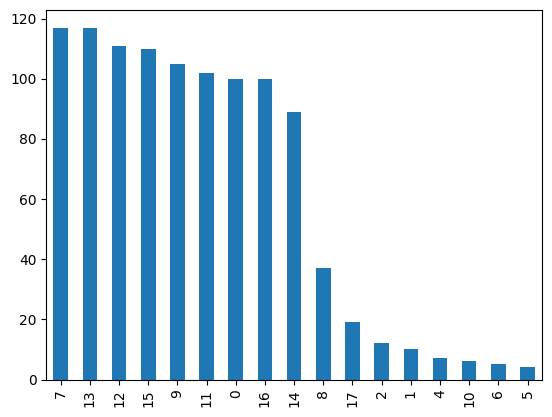

In [90]:
df['LABEL'].value_counts().plot(kind='bar')

In [91]:
np.unique(df['LABEL'])

array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
      dtype=int64)

In [92]:
# train_df, val_df = train_test_split(df, stratify=df.LABEL.values, test_size=0.2, shuffle=True, random_state=42)
# train_df.reset_index(drop=True, inplace=True)
# val_df.reset_index(drop=True, inplace=True)

In [113]:
#Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [94]:
df.head()

,FNAME,LABEL
0,00_107967.bin,1
1,03_794391.bin,15
2,02_193962.bin,7
3,02_720015.bin,0
4,02_781487.bin,14


In [114]:
#Create 5 folds for cross validation
num_folds = 5
train_folds = []
val_folds = []
for i in range(num_folds):
    train_folds.append(df[df.index % num_folds != i].reset_index(drop=True))
    val_folds.append(df[df.index % num_folds == i].reset_index(drop=True))



In [96]:
# train_names = set(train_folds[0]['FNAME'])
# val_names = set(val_folds[0]['FNAME'])

# #See if the sets overlap train_names and val_names
# print(len(train_names.intersection(val_names)))


In [97]:
train_folds[0].shape

(840, 2)

In [115]:
batch_size = 8
train_loaders = []
val_loaders = []

#Create train and validation loaders for each fold
for train_df, val_df in zip(train_folds, val_folds):

    train_ds = ClaSeKDataset(root=DATA_DIR,  # directory where data is
                    split='train',  # train or test
                    df=train_df, # pandas dataframe containing filename and label
                    label_dict=LABEL_DICT,  # label dict: (e.g 10: "car")
                    sensor=sensor,  # sensor to parse scans from
                    max_points=max_points,  # max number of points present in dataset
                    gt=True,
                    transform=True,
                    data_min=norm_min,
                    data_max=norm_max)
    train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
    train_loaders.append(train_loader)

    val_ds = ClaSeKDataset(root=DATA_DIR,  # directory where data is
                    split='train',  # train or test
                    df=val_df, # pandas dataframe containing filename and label
                    label_dict=LABEL_DICT,  # label dict: (e.g 10: "car")
                    sensor=sensor,  # sensor to parse scans from
                    max_points=max_points,  # max number of points present in dataset
                    gt=True,
                    transform=False,
                    data_min=norm_min,
                    data_max=norm_max)
    val_loader = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False)
    val_loaders.append(val_loader)


test_ds = ClaSeKDataset(root=DATA_DIR,  # directory where data is
                split='test',  # train or test
                df=test_df, # pandas dataframe containing filename and label
                label_dict=LABEL_DICT,  # label dict: (e.g 10: "car")
                sensor=sensor,  # sensor to parse scans from
                max_points=max_points,  # max number of points present in dataset
                gt=False,
                transform=False,
                data_min=norm_min,
                data_max=norm_max)
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False)

Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/test


In [116]:
#get next item from train_loader
for i, (proj, label, index) in enumerate(train_loaders[0]):
    print(proj.shape)
    print(label.shape)
    print(index.shape)
    break

torch.Size([8, 5, 64, 2048])
torch.Size([8])
torch.Size([8])


In [100]:
x = proj[0][0:3]
x.shape

torch.Size([3, 64, 2048])

In [101]:
z = torch.zeros_like(x)

In [62]:
R.random().as_matrix().T

array([[-0.24883256,  0.38573548, -0.88842023],
       [-0.96177558, -0.20667999,  0.17964164],
       [-0.11432453,  0.89916157,  0.42241967]])

In [64]:
z =  x @ R.random().as_matrix().T

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 2048)

In [55]:
dx = 1000
dy = 100
z[:, dy:, dx:] = x[:, :-dy, :-dx]

In [76]:
np.random.randint(-10, 10)

-6

In [77]:
x.shape

torch.Size([3, 64, 2048])

In [56]:
x[:, :-dy, :-dx]

tensor([], size=(5, 0, 1048))

In [48]:
x[0, :, 0]

tensor([0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807,
        0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807,
        0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807,
        0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807,
        0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807,
        0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807,
        0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807, 0.2807,
        0.0608])

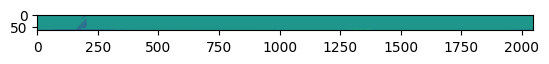

In [57]:
plt.imshow(x[0, :, :])

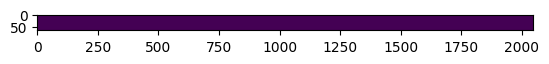

In [58]:
plt.imshow(z[0, :, :])

In [117]:
from sklearn.utils import class_weight
data_loader = train_loaders[0]
def get_class_weights(data_loader, n_classes):
    labels = []
    for _, label, _ in data_loader:
        labels.extend(label.detach().numpy())

    labels = np.array(labels, dtype=np.int32)

    unique, counts = np.unique(labels, return_counts=True)
    class_weights = np.ones(n_classes)
    for i, count in zip(unique, counts):
        class_weights[i] = len(labels) / (n_classes*count)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    return class_weights


In [22]:
# train_df, val_df = train_test_split(df, stratify=df.LABEL.values, test_size=0.2)
# train_df.reset_index(drop=True, inplace=True)
# val_df.reset_index(drop=True, inplace=True)    


# train_ds = ClaSeKDataset(root=DATA_DIR,  # directory where data is
#                 split='train',  # train or test
#                 df=train_df, # pandas dataframe containing filename and label
#                 label_dict=LABEL_DICT,  # label dict: (e.g 10: "car")
#                 sensor=sensor,  # sensor to parse scans from
#                 max_points=max_points,  # max number of points present in dataset
#                 gt=True,
#                 transform=False)
# train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
# val_ds = ClaSeKDataset(root=DATA_DIR,  # directory where data is
#                 split='train',  # train or test
#                 df=val_df, # pandas dataframe containing filename and label
#                 label_dict=LABEL_DICT,  # label dict: (e.g 10: "car")
#                 sensor=sensor,  # sensor to parse scans from
#                 max_points=max_points,  # max number of points present in dataset
#                 gt=True,
#                 transform=False)
# val_loader = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False, drop_last=True)

# class_weights = get_class_weights(train_loader, N_CLASSES)

In [23]:
#class_weights = get_class_weights(data_loader, N_CLASSES)

In [24]:

full_ds = ClaSeKDataset(root=DATA_DIR,  # directory where data is
                split='train',  # train or test
                df=df, # pandas dataframe containing filename and label
                label_dict=LABEL_DICT,  # label dict: (e.g 10: "car")
                sensor=sensor,  # sensor to parse scans from
                max_points=max_points,  # max number of points present in dataset
                gt=True,
                transform=False,
                data_min=norm_min,
                data_max=norm_max)
full_dataloader = DataLoader(dataset=full_ds, batch_size=batch_size, shuffle=False, drop_last=False)

Sequences folder exists! Using sequences from ../data/train


 83%|████████▎ | 83/100 [51:56<10:38, 37.55s/it]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.14E-03


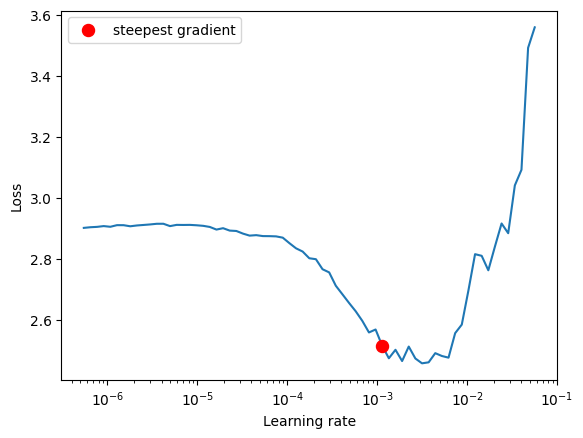

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.001137962040552782)

In [25]:
from torch_lr_finder import LRFinder

model = MoreSalsa(N_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-5)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(full_dataloader, end_lr=2, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
#lr_finder.reset() # to reset the model and optimizer to the

In [ ]:
#get next item from dataset
for i, (proj, label, index) in enumerate(full_dataloader):
    print(proj.shape)
    print(label.shape)

    break

#full_ds

In [ ]:
stat_vect = []
for i, (proj, label, index) in enumerate(full_dataloader):
    print(i)
    print(proj.shape)
    print(label.shape)
    print(index.shape)
    stat_vect.extend(proj)
    

In [ ]:
all_data = torch.stack(stat_vect)
all_data.shape

In [ ]:
# get the average over the C dimensions (5 of them)
C = all_data.shape[1]
#First we Normalize to get the data in range [0, ~1], then we standardize the data to have mean 0 and std 1
norm_min = []
norm_max = []
z_mean = []
z_std = []

for i in range(C):
    x = all_data[:,i,:,:].reshape(-1).numpy()
    
    min = x.min()
    max = x.max()
    #Normalize
    x = (x - min)/(max - min)

    #Standardize
    mean = x.mean()
    std = x.std()
    
    norm_min.append(min)
    norm_max.append(max)
    z_mean.append(mean)
    z_std.append(std)
   
    print(f'{i} min: {min} max: {max} mean: {mean} std: {std}')

In [ ]:
def scale_data(X, norm_min, norm_max, z_mean, z_std):
    C = X.shape[1]
    eps = 1e-8
    for i in range(C):
        X[:,i,:,:] = (X[:,i,:,:] - norm_min[i])/(norm_max[i] - norm_min[i])
        #X[:,i,:,:] = (X[:,i,:,:] - z_mean[i])/(z_std[i] + eps)
    return X

In [ ]:
for i, (proj, label, index) in enumerate(full_dataloader):
    print(f'{i} Unscaled: min: {proj.min()} max: {proj.max()} mean: {proj.mean()} std: {proj.std()}')
    proj = scale_data(proj, norm_min, norm_max, z_mean, z_std)
    
    #Min, max, mead, std
    print(f'{i} min: {proj.min()} max: {proj.max()} mean: {proj.mean()} std: {proj.std()}')    
    

In [ ]:
x = all_data[0,0,:,:].reshape(-1).numpy()
x = (x - (-14.726127624511719))/(37.73949432373047 - (-14.726127624511719))

In [ ]:
x.min(), x.max(), x.mean(), x.std()

In [ ]:
plt.hist(x);

In [ ]:
DATA_MEAN

In [ ]:
for i, (proj, label, index) in enumerate(train_loaders[0]):
    #Shape the data so that each channel can be scaled separately
    channels = []
    for c in range(proj.shape[1]):
        channels.append(proj[:,c,:,:].numpy().reshape(-1))

    

   
    break

In [ ]:
#model = SimpleModel3(num_channels=5, num_classes=N_CLASSES, input_shape=(64, 2048))

In [ ]:
#output = model(proj)

In [ ]:
# #load state dict if available
# fileName = '../models/salsanext_2023-10-15_01-15-16.pth'
# if os.path.isfile(fileName):
#     print("Loading model...")
#     model.load_state_dict(torch.load(fileName))

In [118]:
def train_epoch(epoch, model, loader, criterion, optimizer, device, scheduler):
    model.train()
    loss_list = list()
    pbar = tqdm(total=len(loader), desc=f'Epoch {epoch}')
    for i, (data, proj_labels, _) in enumerate(loader):
        data = data.float().to(device)
        label = proj_labels.long().to(device)
        optimizer.zero_grad()
        logit = model(data)
        loss = criterion(logit, label)
        loss.backward()
        optimizer.step()
        scheduler.step()   
        loss_list.append(loss.item())
        pbar.update(1)
        pbar.set_postfix({'Loss': np.mean(loss_list)})
    pbar.close()
    return np.mean(loss_list)

def validate_epoch(epoch, model, loader, criterion, device):
    model.eval()
    loss_list = list()
    gts = list()
    preds = list()
    pbar = tqdm(total=len(loader), desc=f'Epoch {epoch}')
    with torch.no_grad():
        for i, (data, proj_labels,_) in enumerate(loader):
            data = data.float().to(device)
            label = proj_labels.long().to(device)
            logit = model(data)
            pred = torch.argmax(logit, dim=1)
            gts.extend(label.detach().cpu().numpy().tolist())
            preds.extend(pred.detach().cpu().numpy().tolist())
            loss = criterion(logit, label)
            loss_list.append(loss.item())
            pbar.update(1)
            pbar.set_postfix({'Loss': np.mean(loss_list)})
    pbar.close()
    gts = np.array(gts)
    preds = np.array(preds)
    acc = accuracy_score(y_true= gts, y_pred=preds)
    return np.mean(loss_list), acc


In [119]:
# Add the day and time of training to the model name
import datetime
now = datetime.datetime.now()
model_name = f'salsanext_{now.strftime("%Y-%m-%d_%H-%M-%S")}'
model_base_path = '../models/'
model_path = os.path.join(model_base_path, model_name)
submission_path = os.path.join(model_base_path, f'submission_{model_name}.csv')
print(model_path)
print(submission_path)

../models/salsanext_2023-10-24_10-37-19
../models/submission_salsanext_2023-10-24_10-37-19.csv


In [120]:
epoch = 0
total_epoch = 100
train_losses = list()
val_losses = list()
val_accs = list()
best_val_acc = 0
best_val_loss = np.inf


In [31]:
#Keep training
#total_epoch = 10

In [121]:
#Create a new model for each fold
for fold, (train_loader, test_loader) in enumerate(zip(train_loaders, val_loaders)):

    print(f'Fold {fold}/{len(train_loaders)}')

    #Get the class weights for the current fold
    class_weights = get_class_weights(train_loader, N_CLASSES)

    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    
    #model = SalsaNext(nclasses=N_CLASSES).to(device)
    #model = BetterSalsa(nclasses=N_CLASSES, num_layers=8, num_filters=64, dropout_rate=0.2, stride=1, channels=5).to(device)
    #model = SkynetCNN(num_classes=18, in_channels=5, num_layers=6).to(device)
    model = MoreSalsa(N_CLASSES).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5*1e-3)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 1e-4, 2*1e-3, step_size_up=450, mode='triangular2', cycle_momentum=False)

    epoch = 0
    best_val_acc = 0
    save_no = 0
    while epoch < total_epoch:
        train_loss = train_epoch(epoch, model, train_loader, criterion, optimizer, device, scheduler)
        val_loss, val_acc = validate_epoch(epoch, model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'{model_path}_fold_{fold}_save_{save_no}.pth')
            print(f'Saving model at epoch: {epoch}, val acc: {val_acc}')
            #save_no += 1

        print(f'Epoch: {epoch} Current val acc is {val_acc} while the best val acc is {best_val_acc}')
         
        epoch += 1

    
    break #Only train on one fold


Fold 0/5


RuntimeError: The expanded size of the tensor (64) must match the existing size (0) at non-singleton dimension 1.  Target sizes: [5, 64, 2031].  Tensor sizes: [5, 0, 2031]

In [ ]:
#plot the losses as a function of epochs
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
plt.plot(val_accs, label="Validation accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
def generate_submission_file(model, loader, device):
    model.eval()
    indices_list = list()
    preds = list()
    #pbar = tqdm(total=len(loader), desc=f'Epoch {epoch}')
    pbar = tqdm(total=len(loader))
    with torch.no_grad():
        for i, (data, proj_labels, indices) in enumerate(
                loader):
            data = data.float().to(device)
            label = proj_labels.long().to(device)
            logit = model(data)
            pred = torch.argmax(logit, dim=1)
            indices_list.extend(indices.detach().cpu().numpy().tolist())
            preds.extend(pred.detach().cpu().numpy().tolist())
            print(f'{i} {len(preds)}')
            pbar.update(1)
    pbar.close()
    sample = test_df.iloc[indices_list]
    sample['LABEL'] = preds
    return sample 

In [ ]:
test_df.head()

In [ ]:
#model_path = '../models/salsanext_2023-10-21_23-42-04'

In [ ]:
#Scan models directory and find all models
import glob
model_paths = glob.glob(model_path + '*.pth')
#print(model_paths)


#Extract the file name only and split it to get the fold number
#Then for each foldNo save the path for the one with the highest saveNo
fold_paths = dict()

for path in model_paths:

    #remove the .pth extension
    #print(os.path.basename(path)[:-4].split('_'))
    splits = os.path.basename(path)[:-4].split('_')
    #BaseName, Date, HHMMSS, Fold, FoldNo, save, saveNo
    foldNo = splits[4]
    saveNo = splits[6]

    if foldNo not in fold_paths:
        fold_paths[foldNo] = path
    else:
        if int(saveNo) > int(os.path.basename(fold_paths[foldNo])[:-4].split('_')[6]):
            fold_paths[foldNo] = path


fold_paths





In [ ]:
fold_paths

In [ ]:
device

In [ ]:
modelContainer = ModelContainer()
for path in fold_paths:
    print(f'Fold {path}')
    #model = MoreSalsa(nclasses=N_CLASSES).to(device)
    model = SkynetCNN(num_classes=18, in_channels=5, num_layers=6).to(device)
    model.load_state_dict(torch.load(fold_paths[path]))
    model.eval()
    modelContainer.addModel(model)

In [ ]:
# model = SimpleModel3(num_channels=5, num_classes=N_CLASSES, input_shape=(64, 2048)).to(device)
# model.load_state_dict(torch.load(model_path))
# sample = generate_submission_file(model, test_loader, device)

In [ ]:
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False)

In [ ]:
sample = generate_submission_file(modelContainer, test_loader, device)

In [ ]:
sample.reset_index(drop=True, inplace=True)

In [ ]:
sample

In [ ]:
#submission_path = '../models/submission_salsanext_2023-10-21_23-42-04.csv'

In [ ]:

sample.to_csv(submission_path, index=None)